In [1]:
from nltk.corpus import wordnet as wn
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

Using TensorFlow backend.
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framewo

In [13]:
df=pd.read_csv('labels.csv')

# 1. Small checker 

In [39]:
for i in range(0,25662):
    if df.loc[i,'Words']=='Northrop':
        print("\n")
        print(i)
        print(df.loc[i,'event_id'])
        
        print(df.loc[i,'Words'])
        print(df.loc[i+1,'Words'])
        print(df.loc[i+2,'Words'])
        print(df.loc[i+3,'Words'])
    



16363
662
Northrop
Grumman
B21
longrange


In [15]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Words"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("event_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [16]:
getter = SentenceGetter(df)


In [17]:
words = set(df["Words"].values.tolist())
# words.append("ENDPAD")
n_words = len(words); 
print(n_words)
tags = set(df["Tag"].values.tolist())
n_tags = len(tags); 
print(n_tags)
sent = getter.get_next()
print(sent)



7052
2
[('A', 'DT', 'O'), ('new', 'JJ', 'O'), ('28foot', 'NN', 'O'), ('tall', 'JJ', 'O'), ('statue', 'NN', 'O'), ('of', 'IN', 'O'), ('Jesus', 'NNP', 'arg'), ('dubbed', 'VBN', 'O'), ('de', 'FW', 'arg'), ('Greatest', 'JJS', 'arg'), ('is', 'VBZ', 'O'), ('unveiled', 'VBD', 'O'), (' on ', 'IN', 'O'), ('New', 'NNP', 'arg'), ('Years', 'NNS', 'arg'), ('Day', 'NNP', 'O'), ('outside', 'IN', 'O'), ('St.', 'NNP', 'O'), ('Aloysius', 'NNP', 'O'), ('Catholic', 'NNP', 'O'), ('Church', 'NNP', 'O'), (' in ', 'IN', 'O'), ('Abajah', 'NNP', 'O'), ('village', 'NN', 'O'), ('Nigerias', 'NNP', 'O'), ('Imo', 'NNP', 'O'), ('state', 'NN', 'O'), ('which', 'WDT', 'O'), ('described', 'VBN', 'O'), (' as ', 'IN', 'O'), ('tallest', 'JJS', 'O'), ('Africa', 'NNP', 'O')]


In [18]:
sentences = getter.sentences

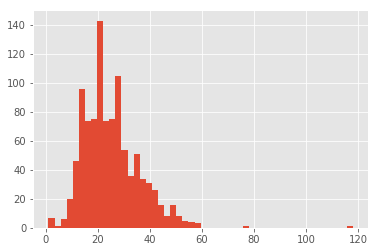

In [19]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [38]:
max_len = 120
word2idx = {w: i for i, w in enumerate(words)} #vocab for words
# print(tag2idx)
tag2idx = {t: i for i, t in enumerate(tags)} #vocab for tags
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [22]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=120, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="sigmoid"))(model)  # softmax output layer
model = Model(input, out)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [23]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=50, validation_split=0.2, verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 822 samples, validate on 92 samples
Epoch 1/50
822/822 [==============================] - 8s 9ms/step - loss: 0.3028 - acc: 0.9359 - val_loss: 0.1224 - val_acc: 0.9573
Epoch 2/50
822/822 [==============================] - 6s 7ms/step - loss: 0.1007 - acc: 0.9605 - val_loss: 0.0950 - val_acc: 0.9573
Epoch 3/50
822/822 [==============================] - 6s 7ms/step - loss: 0.0894 - acc: 0.9605 - val_loss: 0.0942 - val_acc: 0.9573
Epoch 4/50
822/822 [==============================] - 6s 7ms/step - loss: 0.0849 - acc: 0.9605 - val_loss: 0.0959 - val_acc: 0.9573
Epoch 5/50
822/822 [==============================] - 6s 8ms/step - loss: 0.0813 - acc: 0.9604 - val_loss: 0.0950 - val_acc: 0.9574
Epoch 6/50
822/822 [==============================] - 6s 7ms/step - loss: 0.0771 - acc: 0.9617 - val_loss: 0.0988 - val_acc: 0.9573
Epoch 7/50
822/822 [==============================] - 7s 8ms/step - loss: 0.0716 - acc: 0.9656 - val_loss: 0.0957 -

In [24]:
hist = pd.DataFrame(history.history)
# print(hist)

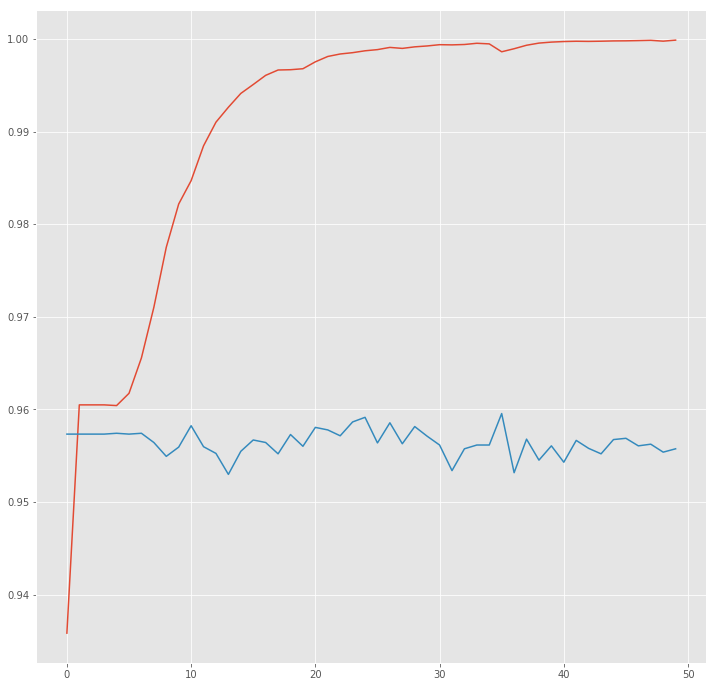

In [25]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [52]:
pred

0

In [55]:
for i in range(10,11):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    print(p[0])
    
    
#     p=np.where(p==2, 0, x)
    
    
#     print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
#     for w, pred in zip(X_te[i], p[0]):
#         print("{:15}: {}".format(list(words)[w], list(tags)[pred]))
#     x=np.where(p==1, 2, p) 
    
#     m=np.where(x==0, 1, x)
# #     print(y)
#     z=np.where(m==2, 0, m)
#     print(z)


[1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [47]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [48]:
test_pred = model.predict(X_te, verbose=1)


102/102 [==============================] - 0s 2ms/step


In [49]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [57]:
test_pred[0]

array([[6.9203973e-04, 9.9934030e-01],
       [1.3139844e-04, 9.9985218e-01],
       [5.8784485e-03, 9.9391711e-01],
       [9.9737775e-01, 2.1252036e-03],
       [9.9993134e-01, 5.5104494e-05],
       [3.6665797e-04, 9.9956787e-01],
       [1.7762184e-05, 9.9997997e-01],
       [3.7884116e-03, 9.9614471e-01],
       [9.9990690e-01, 7.4028969e-05],
       [9.9998325e-01, 1.5854836e-05],
       [9.9999964e-01, 4.1723251e-07],
       [9.9999988e-01, 5.9604645e-08],
       [9.9999988e-01, 1.7881393e-07],
       [9.9978721e-01, 2.4157763e-04],
       [9.9940628e-01, 5.9115887e-04],
       [1.0000000e+00, 2.9802322e-08],
       [9.9999928e-01, 6.8545341e-07],
       [9.9918860e-01, 7.9700351e-04],
       [9.9988365e-01, 1.1765957e-04],
       [9.9968827e-01, 3.1268597e-04],
       [9.9999988e-01, 5.9604645e-08],
       [9.9999988e-01, 1.7881393e-07],
       [9.9999994e-01, 2.3841858e-07],
       [9.9999982e-01, 1.7881393e-07],
       [9.9999976e-01, 1.7881393e-07],
       [9.9999982e-01, 1.

In [50]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 81.0%


In [51]:
print(classification_report(test_labels, pred_labels))


           precision    recall  f1-score   support

      arg       0.82      0.80      0.81       204

micro avg       0.82      0.80      0.81       204
macro avg       0.82      0.80      0.81       204

